# FIT5201_2018S2 Assignment 1 - Section B - Question 3

- <font color='blue'>**Student Id**</font>: 27771539
- <font color='blue'>**Student Name**</font>: Chuangfu Xie
- <font color='blue'>**Packages in use**</font>:
    - `repr`: Provide more control on graphical presentation
    - `ggplot2`: Data visualization package
    - `reshape2`: reshape data

# Section B: Prediction Uncertainty with Bootstrapping

## 0. Import packages:

In [11]:
library(repr)
library(ggplot2)
library(reshape2)

## 1. Implement the KNN regressor function:

In [13]:
boot <- function (original.size=100, sample.size=original.size, times=100){
    # Create an empty data.frame ready for the resampling
    indx <- matrix(nrow=times, ncol=sample.size)
    for (t in 1:times){
        indx[t, ] <- sample(x=original.size, size=sample.size, replace = TRUE)
    }
    return(indx)
}

knn <- function(train.data, train.label, test.data, K=3){
    # get length
    train.len <- nrow(train.data); test.len <- nrow(test.data)
    # Use 'Euclidean' distance
    dist <- as.matrix(dist(rbind(test.data, train.data), method = 'euclidean'))[1:test.len, (test.len+1):(test.len + train.len)]
    # run through test data
    for (i in 1:test.len){
        # find its K nearest neighbours
        sorted_dist_each_row <- sort(dist[i,], index.return = TRUE)
        # get index of its knn
        nn_index <- as.data.frame(sorted_dist_each_row)[1:K,2]
        # get the mean of its knn target value and assign
        test.data[i,'y'] <- mean(train.label[nn_index])
    }
    return (test.data)
}

## 2. Experiment and Plot

### 2.0 Load CSVs

In [12]:
train <- read.csv("./datasets/Task1B_train.csv")
test <- read.csv("./datasets/Task1B_test.csv")
# Preparing for data and label
train.data <- train[,-5]
train.label <- train[,5]
test.data <- test[,-5]
test.label <- test[,5]

### 2.1 Setting parameters for part II

In [ ]:
K <- 20           # Maximum K for KNN 
L <- 100           # number of resampling datasets
N <- 30           # size of each resampling datasets

### 2.2 Bootstrapping for KNN regressor at different K

In [16]:
# generate bootstrap indices:
boot.indx <- boot(nrow(train.data), N, L)
# a dataframe to track the number of missclassified samples in each case
miss <- data.frame('K'=1:K, 'L'=1:L, 'test'=rep(NA,L*K))

# For every k values:
for (k in 1:K){
    # For every resampling dataset
    for (l in 1:L){
        i <- (k-1)*L + l
        indx <- boot.indx[l,] 
        # Record
        miss[i,'K'] <- k; miss[i,'L'] <- l
        # Do knn
        knn_result = knn(train.data[indx, ], train.label[indx], test.data, K=k)
        # calculate and record the train and test missclassification rates
        miss[i,'test'] <-  mean(abs(knn_result[,5]-test.label))
    } 
}

### 2.3 Formatting and Plot

In [ ]:
# reshape for visualization
miss.m <- melt(miss, id=c('K', 'L')) 
names(miss.m) <- c('K', 'L', 'type', 'miss')

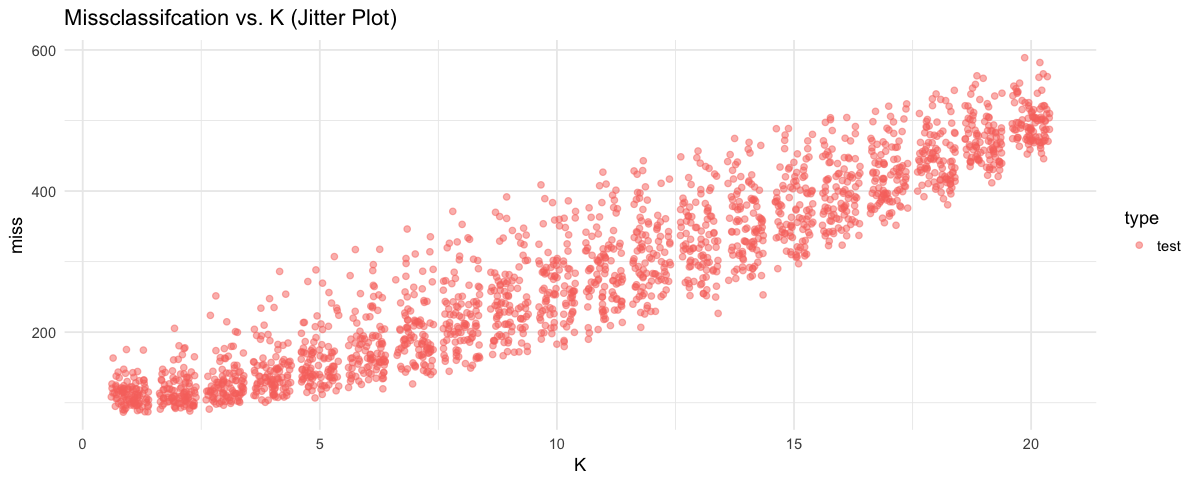

In [21]:
options(repr.plot.width=10, repr.plot.height=4, warn=-1)
ggplot(data=miss.m, aes(x=K, miss, color=type)) + geom_jitter(alpha=0.5)  + 
    scale_fill_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Missclassifcation vs. K (Jitter Plot)') + theme_minimal() 

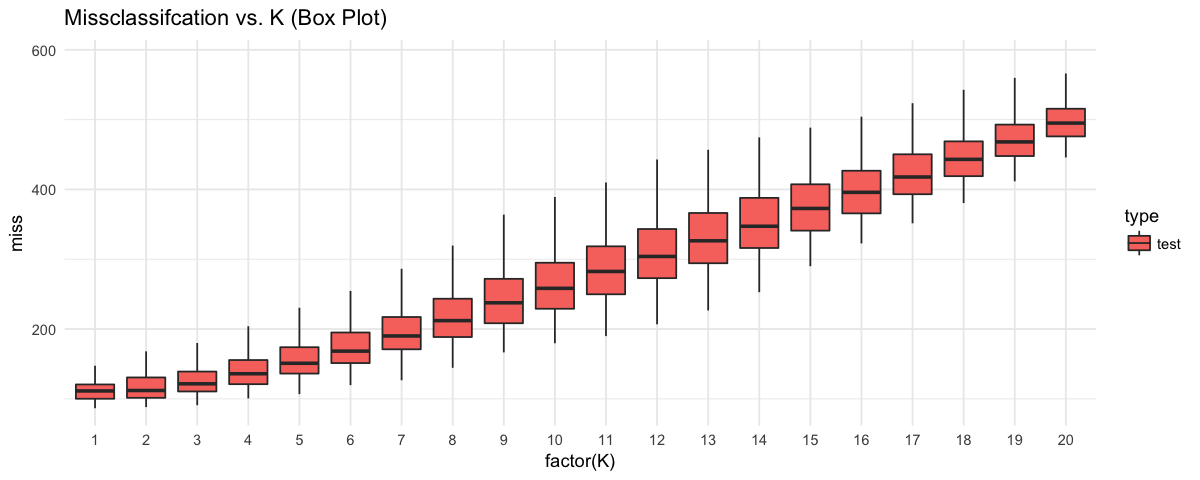

In [20]:
ggplot(data=miss.m[miss.m$type=='test',], aes(factor(K), miss,fill=type)) + geom_boxplot(outlier.shape = NA)  + 
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Missclassifcation vs. K (Box Plot)') + theme_minimal()

### 2.4 Report on part II

From the output illustrated, we can find that:
1. Test error increases when K increaes.
2. The larger the K, the more uncertainty the test error has.

The reason for this phenomenon is that when K increase, the predict value will incrementally approach to the mean of the training dataset. Then, since the deviation will become larger, the averge mean of overall error will also become larger. Hence, the more uncertainty we will have when we use KNN to predict the target value.

### 2.5 Setting parameters for part IV

In [76]:
K <- 10              # Fixed K for KNN 
L <- seq(10,200,10)  # different number of resampling datasets
N <- 50              # size of each resampling datasets

In [92]:
result <- data.frame()
for (l in L){
    boot.indx <- boot(nrow(train.data), N, l)
    miss2 <- data.frame('L'=l, 'l'=1:l, 'test'=rep(NA,l))
    for (i in 1:l){
        indx <- boot.indx[i,] 
        # Do knn
        knn_result = knn(train.data[indx, ], train.label[indx], test.data, K)
        # calculate and record the train and test missclassification rates
        miss2[i,'test'] <-  mean(abs(knn_result[,5]-test.label))
    }
    result <- rbind(result, miss2)
}

In [93]:
# reshape for visualization
result.m <- melt(result, id=c('L', 'l')) 
names(result.m) <- c('L', 'l', 'type', 'miss')

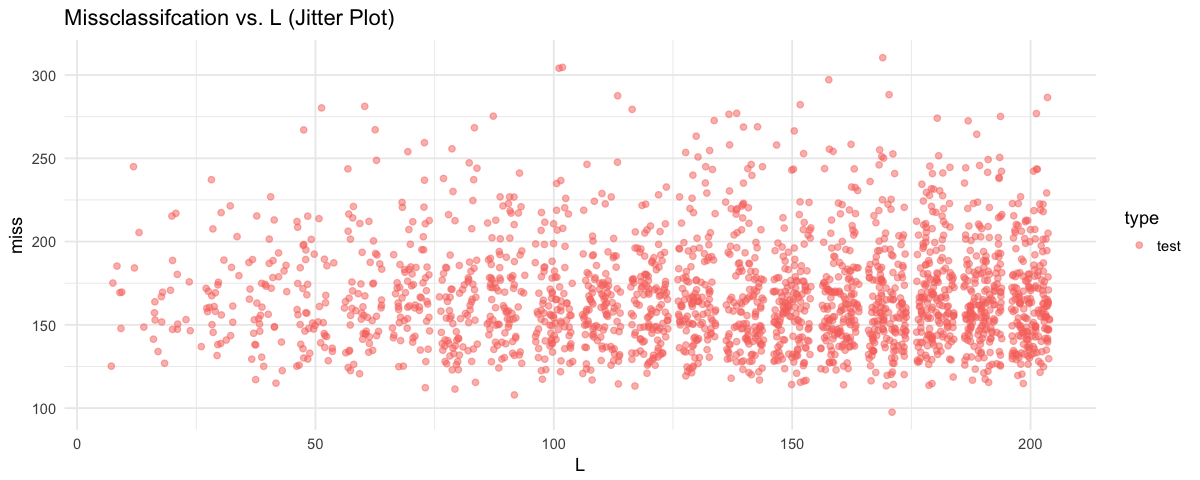

In [94]:
ggplot(data=result.m, aes(x=L, y=miss, color=type)) + geom_jitter(alpha=0.5)  + 
    scale_fill_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Missclassifcation vs. L (Jitter Plot)') + theme_minimal() 

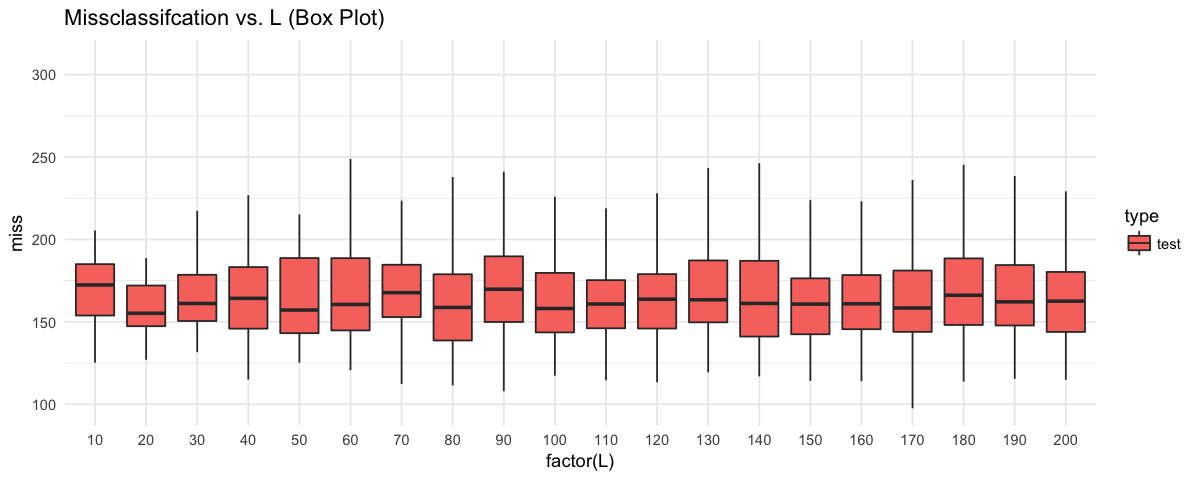

In [95]:
ggplot(data=result.m, aes(factor(L), miss, fill=type)) + geom_boxplot(outlier.shape = NA)  + 
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Missclassifcation vs. L (Box Plot)') + theme_minimal()

### 2.6 Report on part IV

After study on the outputs, we can find that with a fixed K, the large the number of subset we sample, the more stable (certain) the mean of overall the test error.  
By Central Limit Theorem (CLT), it can be clearly explain this phenomenon. The more subset we resample from the ensemble, the mean of our prediction will be more likely to be equal to the mean of the ensumble. This can be also translated into that, the more stable will be the mean of the error.